__Quantum multilabel classification with JAX__

__Author:__ Francesco Aldo Venturelli;
__Date created:__ 2024/07/05;
__Description:__ Quantum convolutional neural network for multilabel image classification written by combining Pennylane with JAX. 
In this simple tutorial we select four different classes of digits images from the *sklearn.datasets.load_digits* and we construct a quantum convolutional neural network to train and make the classification.
After model training we select the last parameters updated and use them to test our model. To have an idea about all the steps needed to complete the experiment we recommend to have a look at the scripts in the */src* folder. Hope this could be useful for you, feel free to use these codes and make further improvements. With this code we would like to emphasize the ability of making multilabel classification and stop of being constrained by binary classifications!

We import all the dependencies and useful scripts.

In [1]:
import sys
sys.path.insert(0, ".../src/")
sys.path.insert(1, ".../dataset/")

In [2]:
from config import *
from src.qcnn_architecture import QCNNArchitecture
from src.utils import *
from src.train import training
from src.plot_results import Plot_results, Plot_Confusion_Matrix

In [3]:
from dataset.digits import X_train, y_train, X_test, y_test, X_val, y_val

In [4]:
from jax import numpy as jnp
import matplotlib.pyplot as plt

We create the __qnode__ where we specify the interface and we measure the probabilities coming from two distinct remained qubits of detecting each class of images. The beauty of a quantum convolutional neural network is the reduction of the number of qubits by a factor of 2 in each layer, which results in a less number of qubits which need to be measured.

In [5]:
@qml.qnode(device=dev, interface="jax")
def qcnn(data: jnp.array, params: jnp.array) -> qml.probs:
    """
    It computes the QCNN architecture and returns probabilities of detecting a class of images.
    :param data: (jnp.array) The input data to encode;
    :param params: (jnp.array) The weights within the layers;
    :return: probs: (list) The probabilities of detecting a class.
    """
    circuit = QCNNArchitecture(device=dev, wires=wires)
    qml.AmplitudeEmbedding(features=data, wires=range(len(wires)), normalize=True, pad_with=0.)
    circuit.QCNN(params)
    probs = qml.probs(wires=[3, 5])
    return probs

# MODEL'S VISUALIZATION
### Let's visualize how the model looks like...

Since the *qcnn* circuit takes in two parameters: data and params, we need to create and provide them in order to display the architecture. In particular, as the model has been constructed, we give 64 features (as the image are (8,8) pixel tensors that are reshaped, and 37 trainable weights.


In [6]:
random_key = jax.random.PRNGKey(seed)
uniform_params = jax.random.uniform(key=random_key, shape=(params_size,))
features = jax.random.uniform(key=random_key, shape=(X_train.shape[0]*X_train.shape[1],1), minval=-1.0, maxval=1.0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)


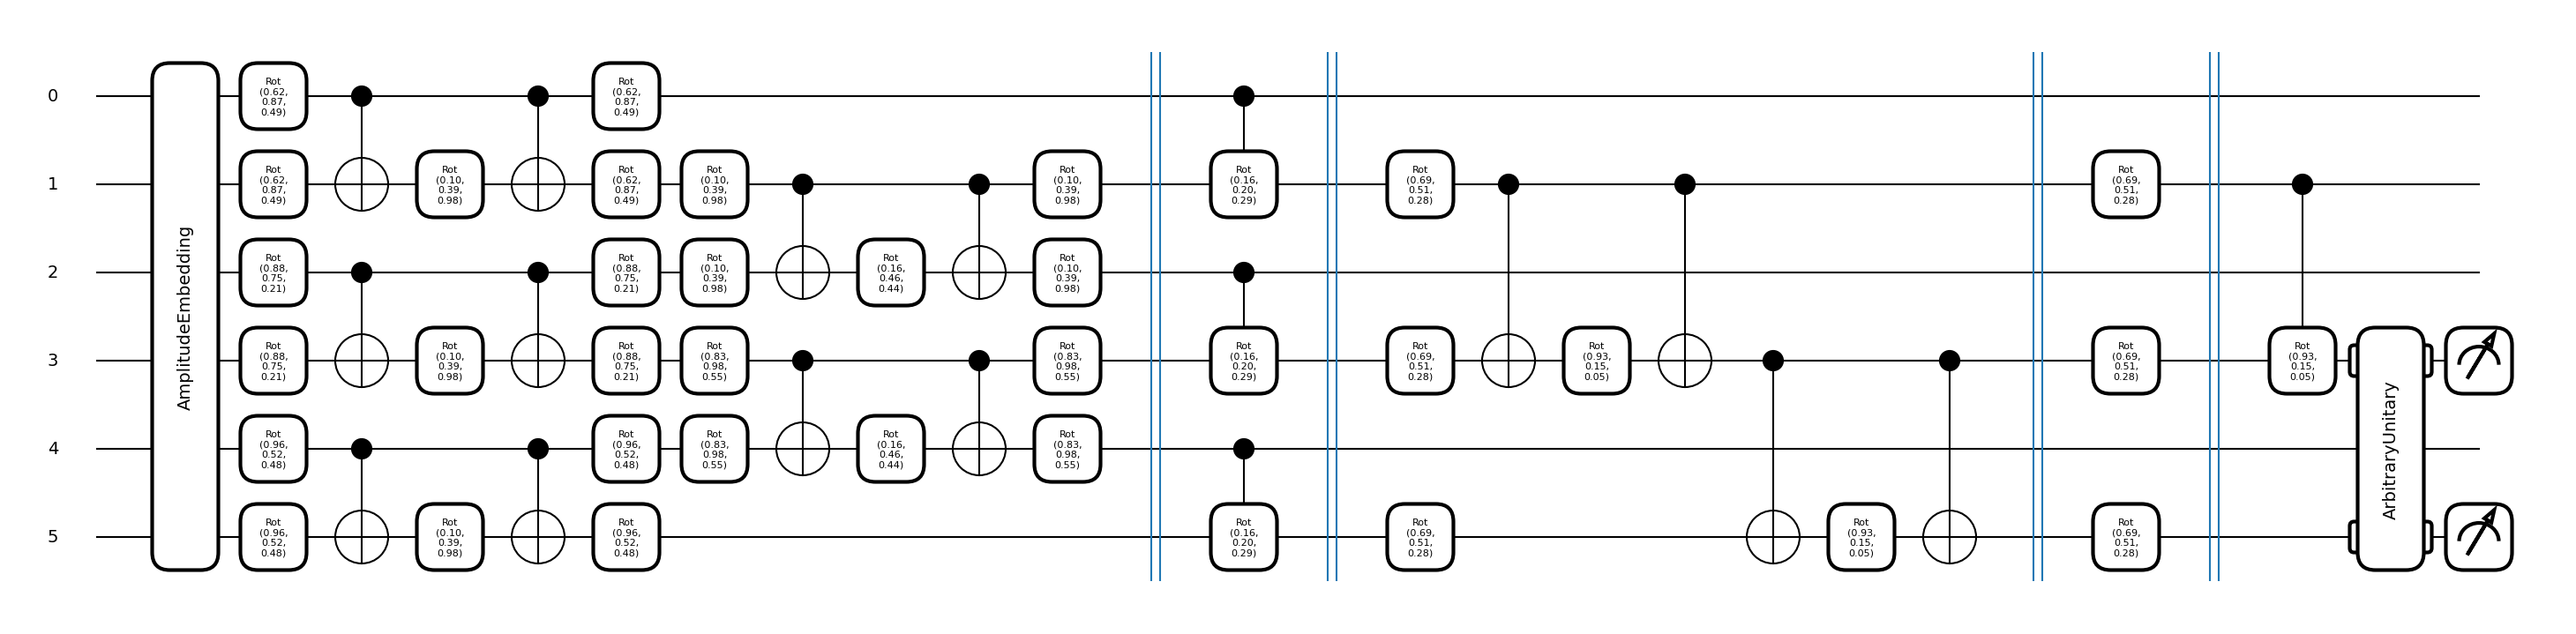

In [7]:
qml.draw_mpl(qnode=qcnn, decimals=2)(features, uniform_params)
plt.show()

# To disable the warning you should type 
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_enable_x64", True)
# before starting.

As we can see, *amplitude* *embedding* is used to encode all the $2^6$ features each image is composed by. By looking at the *qcnn_architecture.py** file, the user can see hwo the quantum convolutional and pooling layers are created, and in the picture, it is visible that each of these elements has the same trainable parameters that repeat. By doing so, we are basically replicating the classical behaviour, where each convolutional layer learns spatial features.

In [6]:
q_model = SelectModel(qcnn)

In [7]:
loss_train, acc_train, loss_val, acc_val, last_params, opt_params = (
    training(seed=seed, model=q_model, selected_shape=params_size, n_epochs=n_epochs,
         batch_size=batch_size, X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val)
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)


Epoch: 1, ---Train loss:  1.3823189 ---Train acc:  0.28611112 | ---Val loss:  1.3806758 ---Val acc:  0.30555555
Epoch: 2, ---Train loss:  1.3629571 ---Train acc:  0.42222223 | ---Val loss:  1.3691199 ---Val acc:  0.4201389
Epoch: 3, ---Train loss:  1.3458041 ---Train acc:  0.5222222 | ---Val loss:  1.3540121 ---Val acc:  0.5208333
Epoch: 4, ---Train loss:  1.3285551 ---Train acc:  0.62777776 | ---Val loss:  1.3412706 ---Val acc:  0.6006944
Epoch: 5, ---Train loss:  1.314161 ---Train acc:  0.6166667 | ---Val loss:  1.3290185 ---Val acc:  0.5833333
Epoch: 6, ---Train loss:  1.304644 ---Train acc:  0.6 | ---Val loss:  1.3191955 ---Val acc:  0.5659722
Epoch: 7, ---Train loss:  1.2999359 ---Train acc:  0.625 | ---Val loss:  1.3120409 ---Val acc:  0.5868056
Epoch: 8, ---Train loss:  1.2963868 ---Train acc:  0.59444445 | ---Val loss:  1.3113904 ---Val acc:  0.5659722
Epoch: 9, ---Train loss:  1.2927957 ---Train acc:  0.6111111 | ---Val loss:  1.3041749 ---Val acc:  0.5763889
Epoch: 10, ---Tra

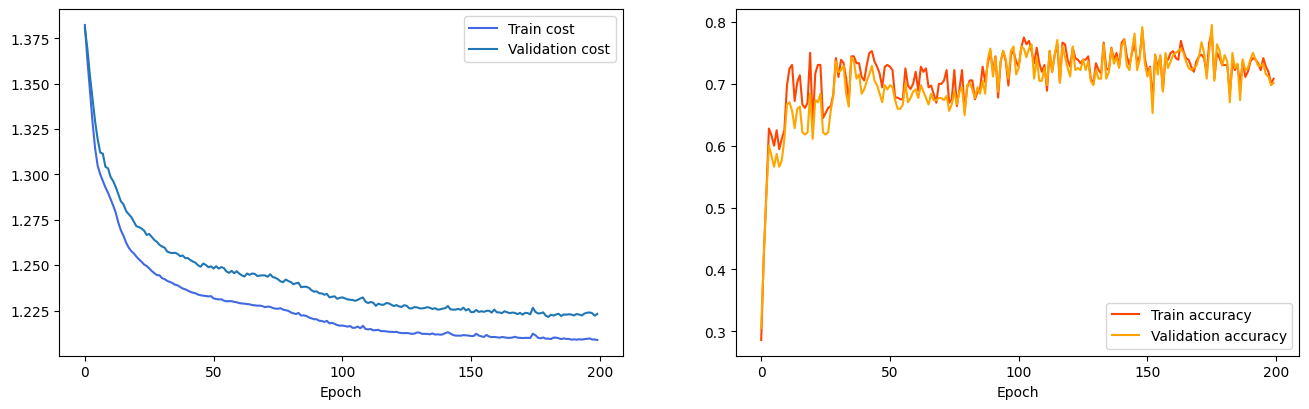

In [8]:
Plot_results(train_cost=loss_train, val_cost=loss_val, train_acc=acc_train, val_acc=acc_val)
plt.show()

In [24]:
test_estimation, test_acc = TestAcc(X=X_test,
                                        y=y_test,
                                        optimal_params=last_params,
                                        quantum_model=q_model)
print("Test acc. QCNN model:", jnp.round(test_acc, 2))

Test acc. QCNN model: 0.71


In [25]:
_, test_acc = TestAcc(X=X_test, y=y_test,
                                        optimal_params=opt_params,
                                        quantum_model=q_model)
print("Test acc. QCNN model:", jnp.round(test_acc, 2))

Test acc. QCNN model: 0.71


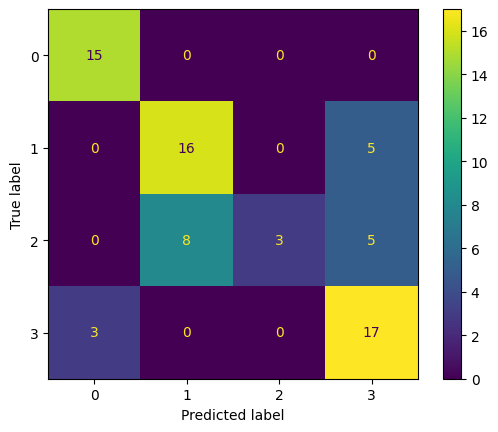

In [26]:
Plot_Confusion_Matrix(y_true=y_test, test_estimation=test_estimation)
plt.show()

__Just a quick comment:__ this is a toy and very simple model which could be improved in several ways: the architecure could be changed, more qubits could be added into it, metrics and loss functions could be adapted to a specific classification task... The point here is that, a low number of trainable parameters (almost half of the encoded features) is enough to obtain, probably not the best classification accuracy within validation and test set, but certainly we have reduced overfitting!
Note also that the dataset has not been balanced, and by reducing or increasing certain classes of images could help in raising up the accuracy during the classification.